In [224]:
import ee
import rasterio
import numpy as np
import pandas as pd
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

In [181]:
ee.Initialize()

In [182]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, get_landsat_images, get_landsat_composite

In [183]:
def ndvi_l5(image):
    return image.normalizedDifference(['B4', 'B3']).rename(['NDVI'])

def ndvi_l8(image):
    return image.normalizedDifference(['B5', 'B4']).rename(['NDVI'])

In [257]:
path, row = [231, 72] # Mamore
p1 = (-63.58, -16.70)
p2 = (-64.22, -16.77)
d = 0.0001
bbox1 = [p1[0], p1[1], p1[0] + d, p1[1] + d]
bbox2 = [p2[0], p2[1], p2[0] + d, p2[1] + d]
start_date = '1984-01-01'
end_date = '2018-01-01'

In [290]:
region = ee.Geometry.Point(p1)
background = ee.Geometry.Point(p1)

def set_mean(image):
    d = image.clip(footprint).reduceRegion(ee.Reducer.first(), region)
    return image.set(d)
  
def set_background(image):
    d = image.clip(footprint).reduceRegion(ee.Reducer.first(), background)
    return image.set(d)

In [282]:
images = ee.ImageCollection([])
ndvis = ee.ImageCollection([])
datasets = ['LANDSAT/LT05/C01/T1_TOA'] #, 'LANDSAT/LE07/C01/T1_TOA', 'LANDSAT/LC08/C01/T1_TOA']
functions = [ndvi_l5] #, ndvi_l5, ndvi_l8]
for dataset, ndvi in zip(datasets, functions):
    x = get_landsat_images(path, row, start_date, end_date, dataset_path=dataset)
    x = x.filter(ee.Filter.lt('CLOUD_COVER', 10))
    images = ee.ImageCollection(x)
    ndvis = images.map(ndvi).map(set_mean)
    control = images.map(ndvi).map(set_background)
    dates = images.aggregate_array('system:time_start').getInfo()
    y1 = ndvis.aggregate_array('NDVI').getInfo()
    y2 = control.aggregate_array('NDVI').getInfo()
    if len(y1) > 0:
        dates = pd.to_datetime(dates, unit='ms')
        data1 = pd.DataFrame({'NDVI' : y1}, index=dates)
        data2 = pd.DataFrame({'NDVI' : y2}, index=dates)
        grouped1 = [group[1].dropna() for group in data1.groupby(pd.TimeGrouper('A'))]
        grouped2 = [group[1].dropna() for group in data2.groupby(pd.TimeGrouper('A'))]
x = ee.Image(images.first())
footprint = x.geometry()

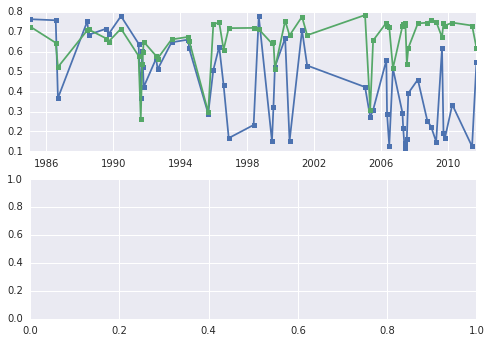

In [267]:
fig, ax = plt.subplots(2,1)
ax[0].plot(data1.index, data1['NDVI'], data2.index, data2['NDVI'], marker='s', markersize=5)
plt.legend(['Mamore tributary', 'Background'])

IndexError: index 0 is out of bounds for axis 0 with size 0

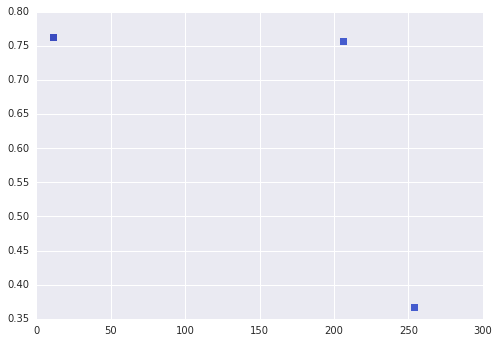

In [270]:
fig, ax = plt.subplots(1,1)
n_years = len(grouped1)
cycle = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, n_years)]
ax.set_color_cycle(cycle)
for dataset in grouped1:
    year = dataset.index.year[0]
    if year % 5 == 0:
        label = year
    else:
        label = ''
    ax.plot(dataset.index.dayofyear, dataset['NDVI'], marker='s', lw=0, label=label)
ax.set_xlim([1, 365])
plt.legend()

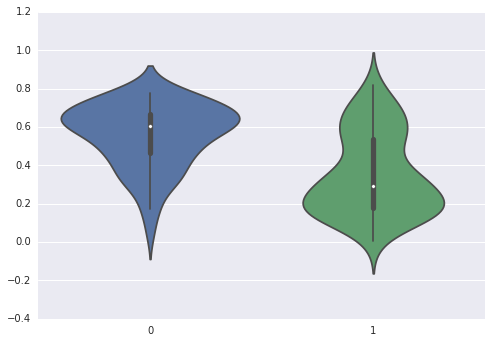

In [229]:
test = data1
before = test.ix[test.index.year <= 1996]
after = test.ix[test.index.year > 1996]
d = sns.violinplot(data=[before.NDVI, after.NDVI])

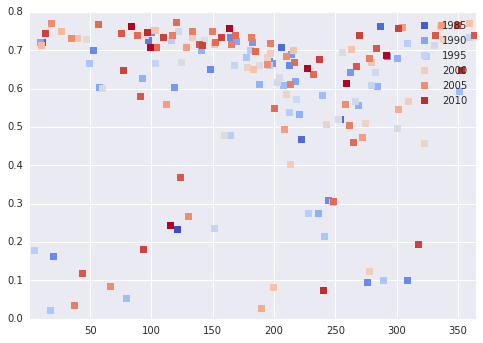

In [192]:
fig, ax = plt.subplots(1,1)
n_years = len(grouped2)
cycle = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, n_years)]
ax.set_color_cycle(cycle)
for dataset in grouped2:
    year = dataset.index.year[0]
    if year % 5 == 0:
        label = year
    else:
        label = ''
    ax.plot(dataset.index.dayofyear, dataset['NDVI'], marker='s', lw=0, label=label)
ax.set_xlim([1, 365])
plt.legend()

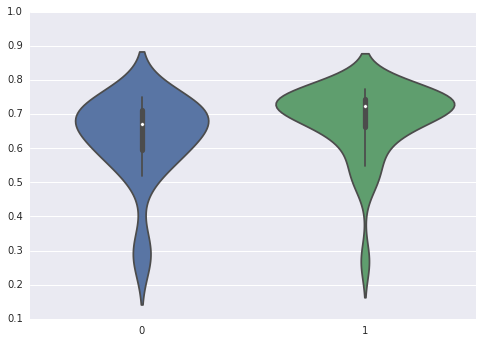

In [256]:
test = data2
before = test.ix[test.index.year <= 1996]
after = test.ix[test.index.year > 1996]
d = sns.violinplot(data=[before.NDVI, after.NDVI])

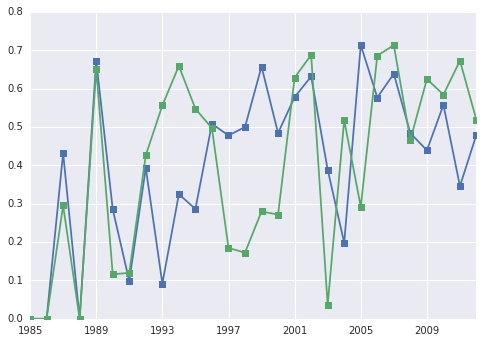

In [190]:
range1 = data1.groupby(pd.TimeGrouper('A'))['NDVI'].max() - data1.groupby(pd.TimeGrouper('A'))['NDVI'].min()
range2 = data2.groupby(pd.TimeGrouper('A'))['NDVI'].max() - data2.groupby(pd.TimeGrouper('A'))['NDVI'].min()

fig, ax = plt.subplots(1,1)
ax.plot(range1.index, range1, marker='s')
ax.plot(range2.index, range2, marker='s')

In [291]:
images = ee.ImageCollection('MODIS/MOD13A1') \
        .filterDate(start_date, end_date)
print(images.size().getInfo())

393


In [293]:
ndvis = images.map(set_mean)
control = images.map(set_background)
print(ee.Image(ndvis.first()).bandNames().getInfo())

[u'NDVI', u'EVI', u'DetailedQA', u'sur_refl_b01', u'sur_refl_b02', u'sur_refl_b03', u'sur_refl_b07', u'ViewZenith', u'SolarZenith', u'RelativeAzimuth', u'DayOfYear', u'SummaryQA']


In [294]:
dates = images.aggregate_array('system:time_start').getInfo()
y1 = ndvis.aggregate_array('NDVI').getInfo()
y2 = control.aggregate_array('NDVI').getInfo()
if len(y1) > 0:
    dates = pd.to_datetime(dates, unit='ms')
    data1 = pd.DataFrame({'NDVI' : y1}, index=dates)
    data2 = pd.DataFrame({'NDVI' : y2}, index=dates)
    grouped1 = [group[1].dropna() for group in data1.groupby(pd.TimeGrouper('A'))]
    grouped2 = [group[1].dropna() for group in data2.groupby(pd.TimeGrouper('A'))]

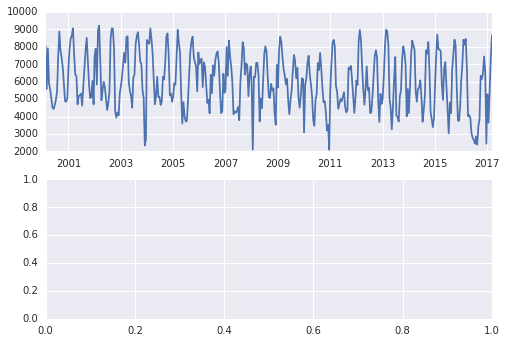

In [296]:
fig, ax = plt.subplots(2,1)
ax[0].plot(data1.index, data2['NDVI'])#, data2.index, data2['NDVI'], marker='s', markersize=5)
plt.legend(['Mamore tributary', 'Background'])